# National Stablecoin



In [1]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np

In [2]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 10
MAX_DEPOSIT_VALUE = 10000
MAX_INFLATION = 5

genesis_states = {
    'fiat_deposit_stable': 0, # Denominated in Stablecoin
    'fiat_deposit_fiat': 0, # Denominated in Fiat
    'fiat_stable_par': 1 # FIAT (base) / STABLE (quote)
}

def p_buy_stablecoin(params, 
                step, 
                state_history, 
                prev_state):
    fiat_amount = np.random.rand()
    fiat_amount = round(fiat_amount * MAX_DEPOSIT_VALUE, 2)
    
    return {'fiat': fiat_amount} # Amount of fiat deposited

def s_fiat_deposit_stable(params, 
                step, 
                state_history, 
                prev_state, _input):
    amount = _input['fiat']
    key = 'fiat_deposit_stable'
    currency_par = prev_state['fiat_stable_par']
    value = prev_state[key] + amount * currency_par
    return (key,value)

def s_fiat_deposit_fiat(params, 
                step, 
                state_history, 
                prev_state, _input):
    amount = _input['fiat']
    key = 'fiat_deposit_fiat'
    value = prev_state[key] + amount
    return (key,value)


def p_inflate_fiat(params, 
                step, 
                state_history, 
                prev_state):
    inflation_rate = np.random.rand()
    inflation_rate = round(inflation_rate * MAX_INFLATION, 2)
    
    return {'inflation': inflation_rate}

def s_fiat_stable_par(params, 
                step, 
                state_history, 
                prev_state, _input):
    inflation_rate = _input['inflation']
    key = 'fiat_stable_par'
    currency_par = prev_state[key]
    value = round(currency_par / ( 1 + inflation_rate / 100 ), 3)
    return (key,value)


partial_state_update_blocks = [
    {
        'policies': {
            'buy_stablecoin': p_buy_stablecoin
            
        },
        'variables': {
            'fiat_deposit_stable': s_fiat_deposit_stable,
            'fiat_deposit_fiat': s_fiat_deposit_fiat
        }
    },
    {
        'policies': {
            'inflation': p_inflate_fiat
            
        },
        'variables': {
            'fiat_stable_par': s_fiat_stable_par
        }
    }
]

sim_config = {
    'N': MONTE_CARLO_RUNS,
    'T': range(SIMULATION_TIMESTEPS),
}

In [3]:
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=genesis_states,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 10, 0, 1, 3)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (10, 0, 1, 3)
Execution Method: local_simulations
Execution Mode: single_threaded
0.6
4.79
0.07
1.0
2.13
1.73
0.47
4.76
2.62
2.93
Total execution time: 0.01s


In [4]:
df = pd.DataFrame(raw_system_events)

In [5]:
df

,fiat_deposit_stable,fiat_deposit_fiat,fiat_stable_par,simulation,subset,run,substep,timestep
0,0.00000,0.00,1.000,0,0,1,0,0
1,9398.60000,9398.60,1.000,0,0,1,1,1
2,9398.60000,9398.60,0.994,0,0,1,2,1
3,18890.47498,18947.77,0.994,0,0,1,1,2
4,18890.47498,18947.77,0.949,0,0,1,2,2
5,22986.04581,23263.44,0.949,0,0,1,1,3
6,22986.04581,23263.44,0.948,0,0,1,2,3
7,31160.73513,31886.53,0.948,0,0,1,1,4
8,31160.73513,31886.53,0.939,0,0,1,2,4
9,31260.45693,31992.73,0.939,0,0,1,1,5


In [6]:
import matplotlib.pyplot as plt

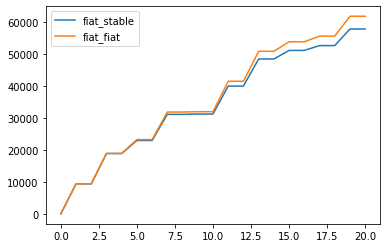

In [7]:
plt.plot(df.index, df.fiat_deposit_stable.values)
plt.plot(df.index, df.fiat_deposit_fiat.values)
plt.legend(['fiat_stable', 'fiat_fiat'])